In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cvxopt

import pickle

# Variable saving.


def pickleSave(var, filename='.pickle'):
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(var, f)
    print('PickleSave Succeeded.')
    return

# Variable loading.


def pickleLoad(filename):
    """
    Make sure it's assigned to a variable.
    """
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'rb') as f:
        cache = pickle.load(f)
    print("PickleLoad Succeeded. Make sure it's assigned to a variable.")
    return cache


In [3]:
def getSupp(x: np.ndarray, s: int = -1):
    """
    Return supp(x_s) corresponding to from Largest to Smallest. \n
    If `s` left default, -1, then s=sum(x!=0).
    """
    if s == -1:
        s = sum(1 - np.isclose(x, 0))
    return np.abs(x).argsort()[:-s-1:-1]


In [2]:
X = pickleLoad('X')
XHat_pR_IRLSPKS = pickleLoad('XHat_pR_IRLSPKS.pickle')
XHat_pR_ModCS = pickleLoad('XHat_pR_ModCS.pickle')
Means = pickleLoad('Means.pickle')
sampMats = pickleLoad('sampMats.pickle')
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
Supps = pickleLoad('Supps.pickle')

styles = ['^-','-.',':','*-',',-','-o','--','+-']

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


reweightedl1

PickleLoad Succeeded. Make sure it's assigned to a variable.


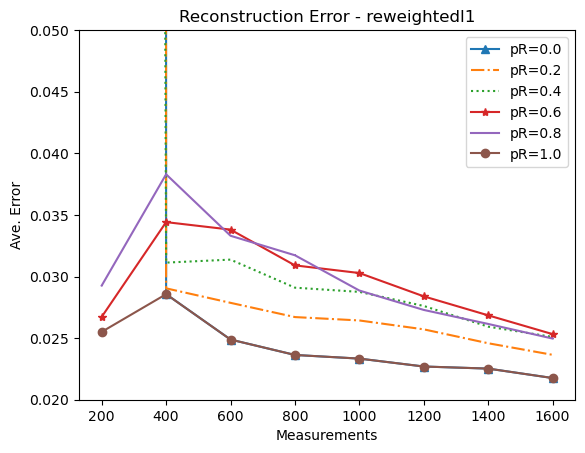

In [18]:
XHat_pR_reweightedl1 = pickleLoad('XHat_pR_reweightedl1')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_reweightedl1[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - reweightedl1')
plt.ylim(0.02,0.05)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


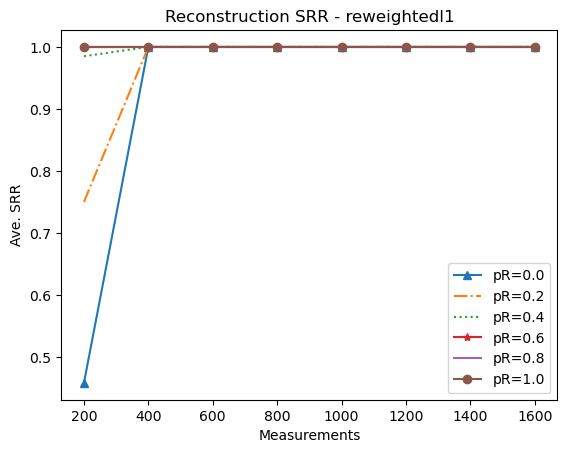

In [8]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_reweightedl1 = pickleLoad('XHat_pR_reweightedl1')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_reweightedl1[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - reweightedl1')
# plt.ylim(0.02,0.05)
plt.show()



IRLSPKS

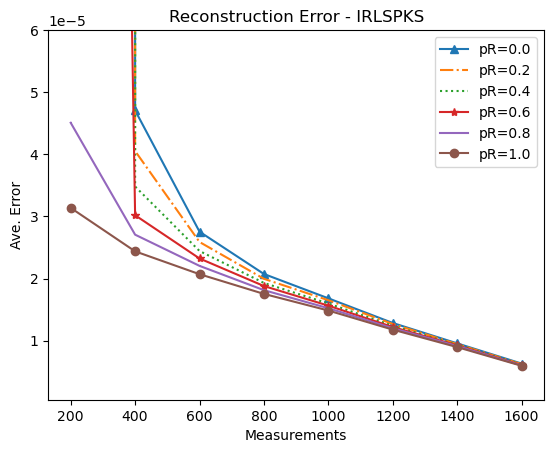

In [5]:
errFig = []
for p in range(6):
    XHat_m = XHat_pR_IRLSPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - IRLSPKS')
plt.ylim(5e-7,6e-5)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


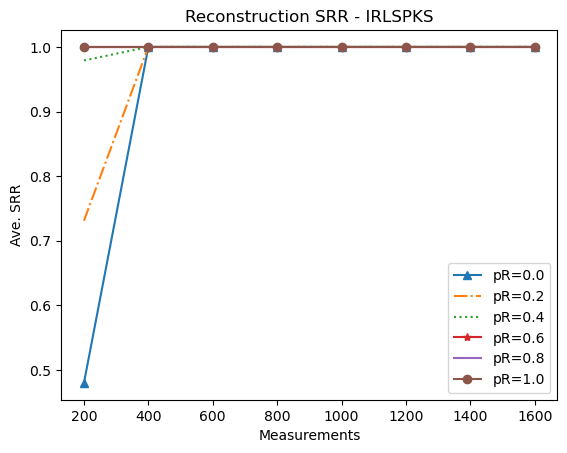

In [9]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_IRLSPKS = pickleLoad('XHat_pR_IRLSPKS')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_IRLSPKS[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - IRLSPKS')
# plt.ylim(0.02,0.05)
plt.show()



modCS

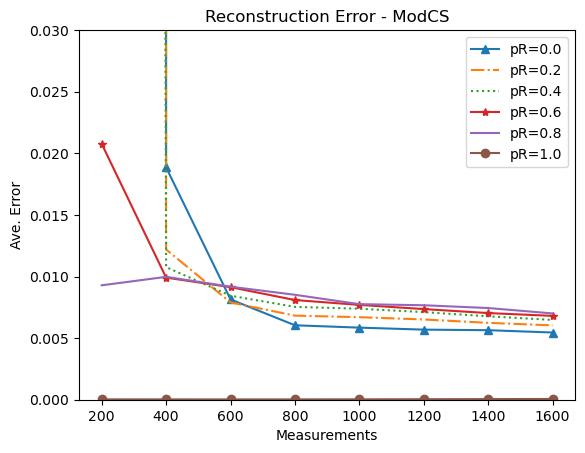

In [16]:
errFig = []
for p in range(6):
    XHat_m = XHat_pR_ModCS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - ModCS')
plt.ylim(0,0.03)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


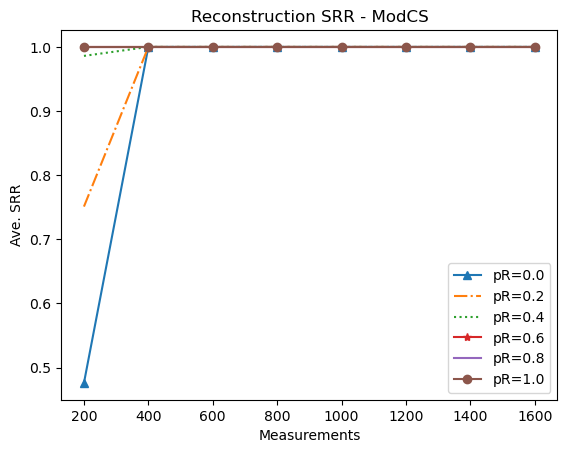

In [10]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_ModCS = pickleLoad('XHat_pR_ModCS')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_ModCS[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - ModCS')
# plt.ylim(0.02,0.05)
plt.show()



CosampPKS

PickleLoad Succeeded. Make sure it's assigned to a variable.


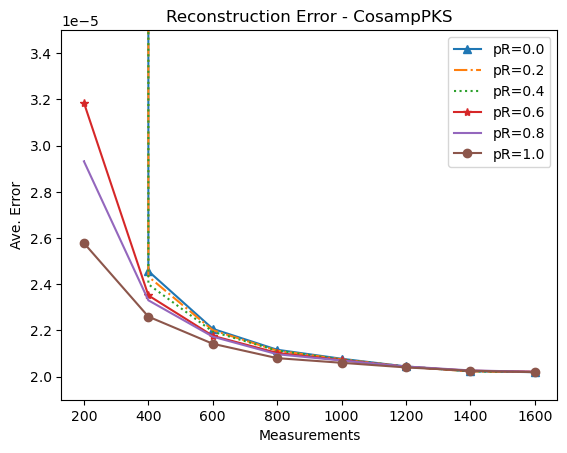

In [7]:
XHat_pR_CosampPKS = pickleLoad('XHat_pR_CosampPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_CosampPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - CosampPKS')
plt.ylim(1.9e-5,3.5e-5)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


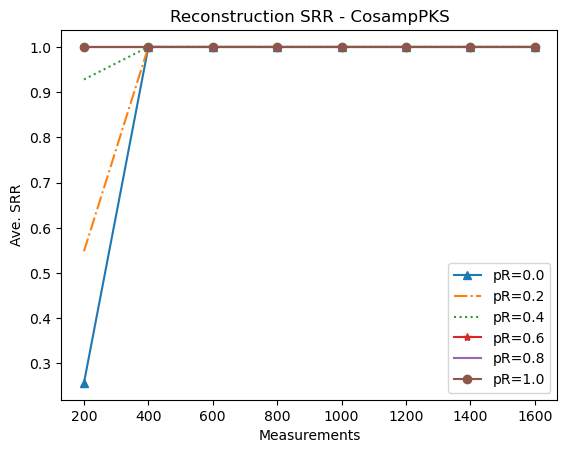

In [13]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_CosampPKS = pickleLoad('XHat_pR_CosampPKS')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_CosampPKS[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - CosampPKS')
# plt.ylim(0.02,0.05)
plt.show()



IHTPKS

PickleLoad Succeeded. Make sure it's assigned to a variable.


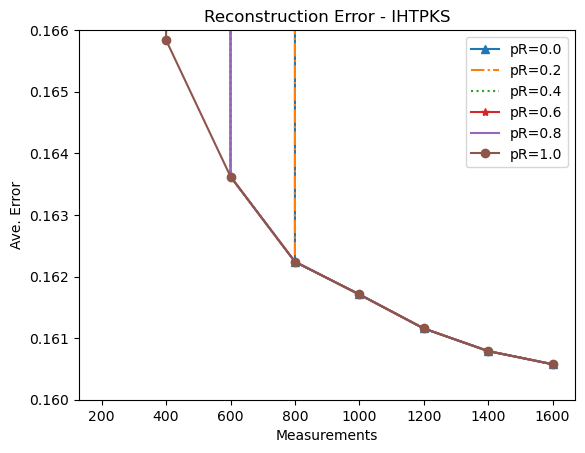

In [14]:
XHat_pR_IHTPKS = pickleLoad('XHat_pR_IHTPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_IHTPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum(np.abs(XHat - X))/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - IHTPKS')
plt.ylim(0.16,0.166)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


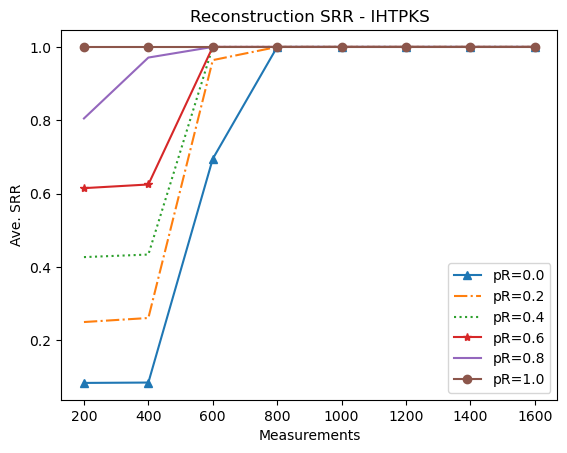

In [12]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_IHTPKS = pickleLoad('XHat_pR_IHTPKS')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_IHTPKS[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - IHTPKS')
# plt.ylim(0.02,0.05)
plt.show()



OMPPKS

PickleLoad Succeeded. Make sure it's assigned to a variable.


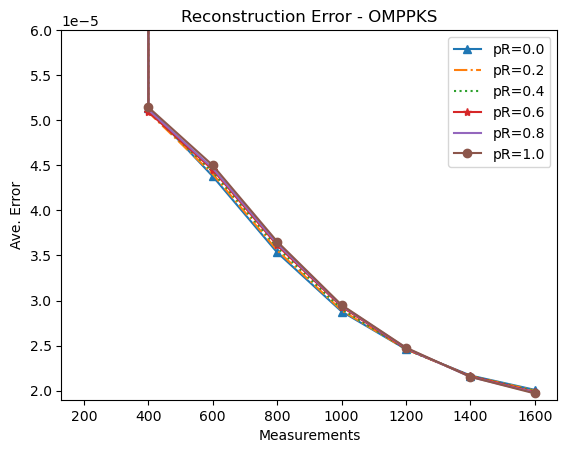

In [144]:
XHat_pR_OMPPKS = pickleLoad('XHat_pR_OMPPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_OMPPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - OMPPKS')
plt.ylim(1.9e-5,6e-5)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


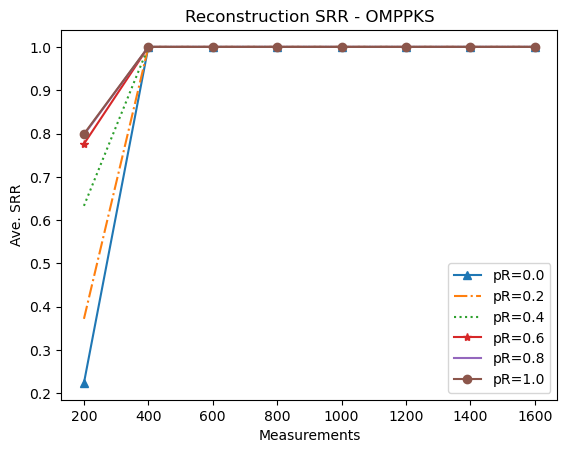

In [14]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_OMPPKS = pickleLoad('XHat_pR_OMPPKS')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_OMPPKS[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - OMPPKS')
# plt.ylim(0.02,0.05)
plt.show()



RWLSSl0PKS

PickleLoad Succeeded. Make sure it's assigned to a variable.


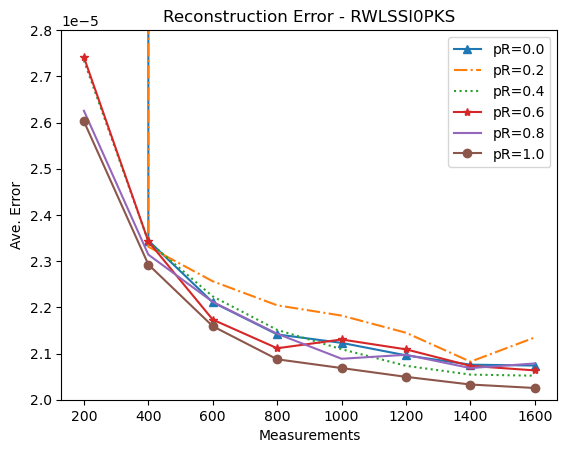

In [145]:
XHat_pR_RWLSSl0PKS = pickleLoad('XHat_pR_RWLSSl0PKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_RWLSSl0PKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - RWLSSl0PKS')
plt.ylim(2e-5,2.8e-5)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


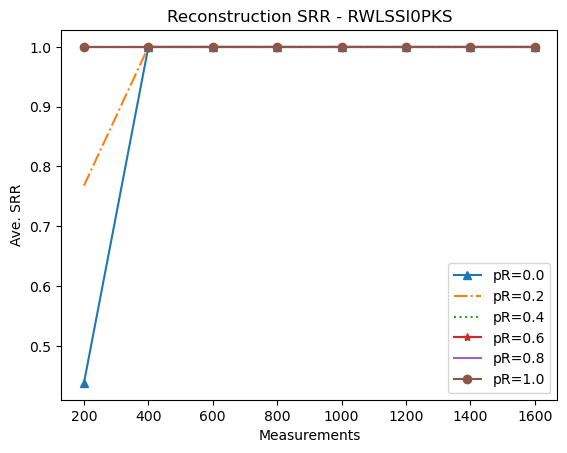

In [15]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_RWLSSl0PKS = pickleLoad('XHat_pR_RWLSSl0PKS')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_RWLSSl0PKS[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - RWLSSl0PKS')
# plt.ylim(0.02,0.05)
plt.show()



weightedl1

PickleLoad Succeeded. Make sure it's assigned to a variable.


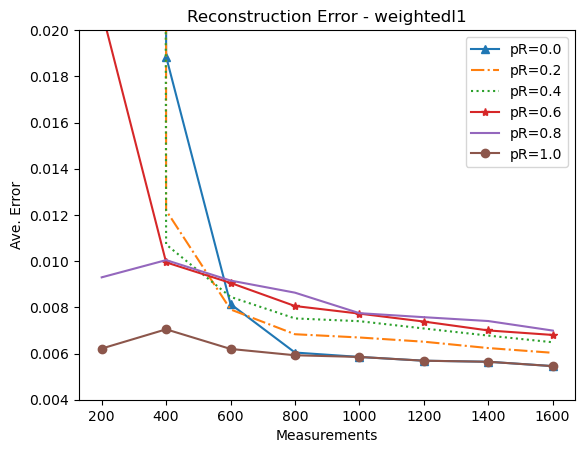

In [155]:
XHat_pR_weightedl1 = pickleLoad('XHat_pR_weightedl1.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_weightedl1[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - weightedl1')
plt.ylim(4e-3,2e-2)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


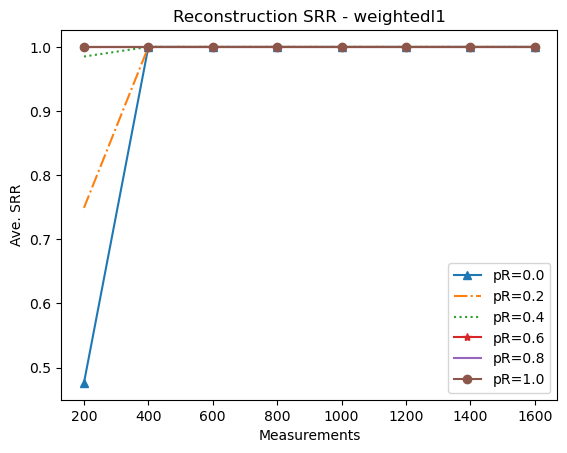

In [16]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_weightedl1 = pickleLoad('XHat_pR_weightedl1')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_weightedl1[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - weightedl1')
# plt.ylim(0.02,0.05)
plt.show()



regModBPDN

PickleLoad Succeeded. Make sure it's assigned to a variable.


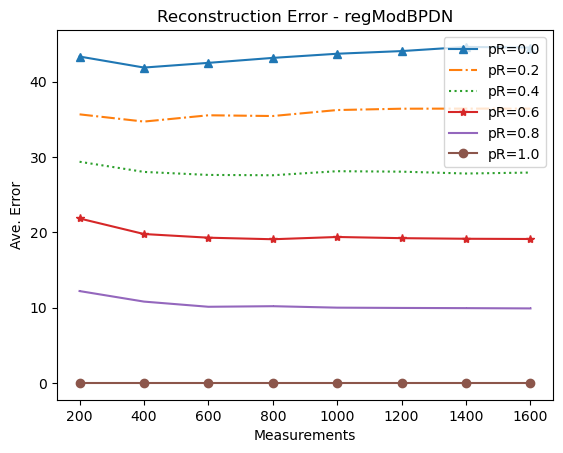

In [20]:
XHat_pR_regModBPDN = pickleLoad('XHat_pR_regModBPDN.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_regModBPDN[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - regModBPDN')
# plt.ylim(2e-5,3e-5)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


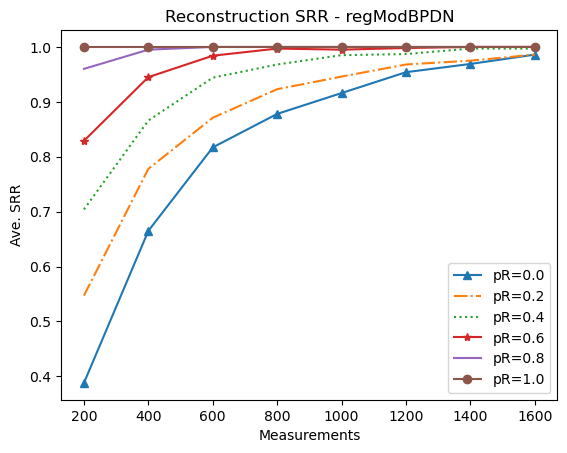

In [17]:
#  F1-score(SRR/Support recovery ratio)

XHat_pR_regModBPDN = pickleLoad('XHat_pR_regModBPDN')
SRRFig = []
for p in range(6):
    XHat_m = XHat_pR_regModBPDN[p]
    SRR = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        TPs = []
        for j in range(XHat.shape[1]):
            tp = len(set(getSupp(XHat[:,j], 50)) & set(getSupp(Means[:,j])))  # True positive.
            TPs.append(tp)
        SRR.append(np.mean(TPs)/50)
    SRRFig.append(SRR)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,SRRFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. SRR')
plt.title('Reconstruction SRR - regModBPDN')
# plt.ylim(0.02,0.05)
plt.show()



Note: 在欠采样时pR越大一般恢复误差越小，而采样数足够多时，不准确的先验信息可能会制约恢复的精确性。